<a href="https://colab.research.google.com/github/opinner/Articles/blob/main/Articles/Introduction_to_Cartopy_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<CENTER>
<H1 style="color:black">
Introduction to Cartopy - Part 2
</H1>
</CENTER>

# **Disclaimer**
This notebook is based on work from a ASTG python course. I updated the code, corrected mistakes and split the content in 2 parts, of which the 2nd one can be found here.

---
All this is also uploaded to my personal github page. There you can also access the interactive version if you click the link to Google Colaboratory. *Ole Pinner*
              

# Table of Contents:

- Bathymetry &
  - *Map shading* (Does not yet work)
  - IBSCO data set
- Satellite images
- Shape files
- Natural Earth Data set

- Cartopy vs Basemap

---

<font color='red'> Only run the following cell if you are on Google Colab</font>

Uncomment the cell below if you are on Google Colab.

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (7.2.1-1~focal0).
proj-bin is already the newest version (7.2.1-1~focal0).
proj-data is already the newest version (7.2.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.9.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/s

Use the following:

```python
    lon = np.linspace(-80, 80, 25)
    lat = np.linspace(30, 70, 25)   
    lon2d, lat2d = np.meshgrid(lon, lat)
    data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)
```

to plot `data` on a Orthographic projection centered in Mexico.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features

In [ ]:
print(cartopy.__version__)

0.21.1


# Displaying Text on maps
https://adjusttext.readthedocs.io/en/latest/Examples.html#adjust_text-also-works-with-cartopy-axes!

# Bathymetry

<font color='red'> Only run the following cell if you are on Google Colab</font>

In [ ]:
!pip install cmocean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scipy.io as sio
import matplotlib.colors as mcolors
import cmocean as cm

In [ ]:
# download bathymetry sample data
!wget https://nextcloud.awi.de/s/ZDMfHAFnpocoi2N/download/WeddellSea_Bat.mat

--2023-06-07 10:18:33--  https://nextcloud.awi.de/s/ZDMfHAFnpocoi2N/download/WeddellSea_Bat.mat
Resolving nextcloud.awi.de (nextcloud.awi.de)... 134.1.2.153
Connecting to nextcloud.awi.de (nextcloud.awi.de)|134.1.2.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45803264 (44M) [application/octet-stream]
Saving to: ‘WeddellSea_Bat.mat.1’

WeddellSea_Bat.mat. 100%[===================>]  43.68M  19.9MB/s    in 2.2s    

2023-06-07 10:18:36 (19.9 MB/s) - ‘WeddellSea_Bat.mat.1’ saved [45803264/45803264]



In [ ]:
bat_data = sio.loadmat("./WeddellSea_Bat.mat")
bat_lat = bat_data["lat"]
bat_lon = bat_data["lon"]
bat_z = bat_data["z"]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


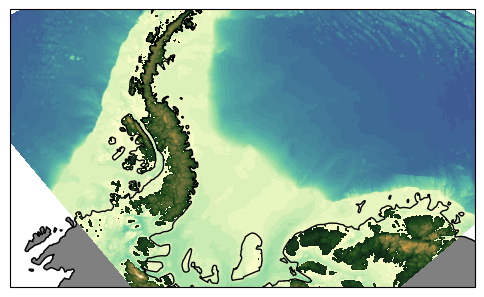

In [ ]:
# Define the projection for a high-resolution South Polar Stereographic map
high_res_proj = ccrs.SouthPolarStereo(central_longitude=-50)
high_res_proj.threshold = 1e3

# Create a new figure and subplot with the specified projection
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': high_res_proj},
                        figsize=(6,4))

# Add the land feature to the map with specified appearance
ax.add_feature(cfeature.LAND, color="grey")
ax.coastlines()

# Define the limits for the x-axis and y-axis of the map
xlim = [-80, -20] # longitude
ylim = [-60, -80] # latitude

# To make sure that all of the wanted map extent is visible in the figure,
# (especially because the chosen map projections differs strongly
# at the poles from the PlateCarree Projection)
# this hack of adding a constant is needed and may need be adjusted,
# dependent on your map extent and figure size
ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]])


divnorm = mcolors.TwoSlopeNorm(vcenter=0)
image = ax.contourf(bat_lon, bat_lat, bat_z, levels = 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)

## Map shading
We will use the HillShade class from the [gvpy library](https://gunnarvoet.github.io/gvpy/maps.html) by Gunnar Voet here, which itself is based on [this python notebook from AgileScientific](https://github.com/agilescientific/notebooks/blob/master/Colourmaps.ipynb).


<font color='red'> Only run the following cell if you are on Google Colab</font>

In [ ]:
!pip install git+https://github.com/gunnarvoet/gvpy
!pip install lat-lon-parser #implicit requirement of gvpy
import gvpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gunnarvoet/gvpy to /tmp/pip-req-build-ijonp7bo
  Running command git clone --filter=blob:none --quiet https://github.com/gunnarvoet/gvpy /tmp/pip-req-build-ijonp7bo
  Resolved https://github.com/gunnarvoet/gvpy to commit 2a1935e34e7a0905422499d5ef7dd3846bad7ced
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.2 MB/s eta 0:00:00
  Created wheel for gvpy: filename=gvpy-0.2.0-py2.py3-none-any.whl size=71458 sha256=a9ef7deb137c9a0ab76a7089e5d5531648c6b7ab3125eb847b888e503098e486
  Stored in directory: /tmp/pip-ephem-wheel-cache-s7wj6ben/wheels/3f/4f/82/0a62101e81ad3b3fa70d043f3b140b60e026709e20b1294181
Successfully built gvpy
Looking in indexes: https://py

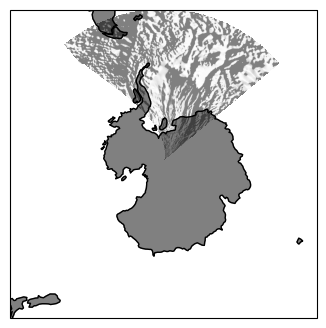

In [ ]:
# Define the projection for a high-resolution South Polar Stereographic map
high_res_proj = ccrs.SouthPolarStereo(central_longitude=-50)
#high_res_proj.threshold = 1e3

# Create a new figure and subplot with the specified projection
fig, ax = plt.subplots(1,
                        subplot_kw={'projection': high_res_proj},
                        figsize=(6,4))

# Add the land feature to the map with specified appearance
ax.add_feature(cfeature.LAND, color="grey")
ax.coastlines()

# Define the limits for the x-axis and y-axis of the map
xlim = [-80, -20] # longitude
ylim = [-60, -80] # latitude

# To make sure that all of the wanted map extent is visible in the figure,
# (especially because the chosen map projections differs strongly
# at the poles from the PlateCarree Projection)
# this hack of adding a constant is needed and may need be adjusted,
# dependent on your map extent and figure size
#ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]])
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

divnorm = mcolors.TwoSlopeNorm(vcenter=0)
#image = ax.contourf(bat_lon, bat_lat, bat_z, 60, transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)

hs = gvpy.maps.HillShade(topo = bat_z, lon = bat_lon, lat = bat_lat)
ax.imshow(
    hs.smoothbumps,
    extent=hs.topo_extent,
    cmap=hs.kmap4,
    alpha=0.5,
    zorder=10,
    transform=ccrs.PlateCarree()
)

In [ ]:
np.any(np.isnan(bat_z))

True

In [ ]:
print(hs.topo_extent,np.shape(hs.smoothbumps))

(-89.96945156382152, -0.004573782980062036, -49.90131637577134, -89.98373007633128) (1566, 1642)


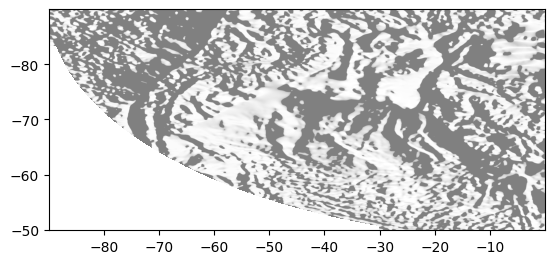

In [ ]:
fig, ax = plt.subplots(1)
hs = gvpy.maps.HillShade(topo = bat_z, lon = bat_lon, lat = bat_lat)
ax.imshow(
    hs.smoothbumps,
    extent=hs.topo_extent,
    cmap=hs.kmap4,
    alpha=0.5,
    origin = "lower",
    zorder=10,
)

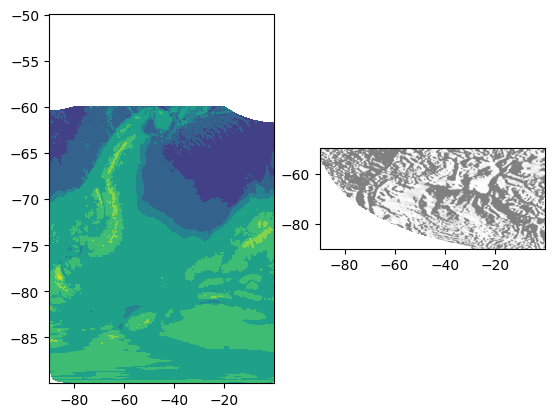

In [ ]:
fig, ax = plt.subplots(ncols = 2)#, sharex = True, sharey = True)
ax[0].contourf(bat_lon, bat_lat, bat_z, 10)

hs = gvpy.maps.HillShade(topo = bat_z, lon = bat_lon, lat = bat_lat)
ax[1].imshow(
    hs.smoothbumps,
    extent=hs.topo_extent,
    cmap=hs.kmap4,
    alpha=0.5,
    zorder=10,
)

ax[1].invert_yaxis()

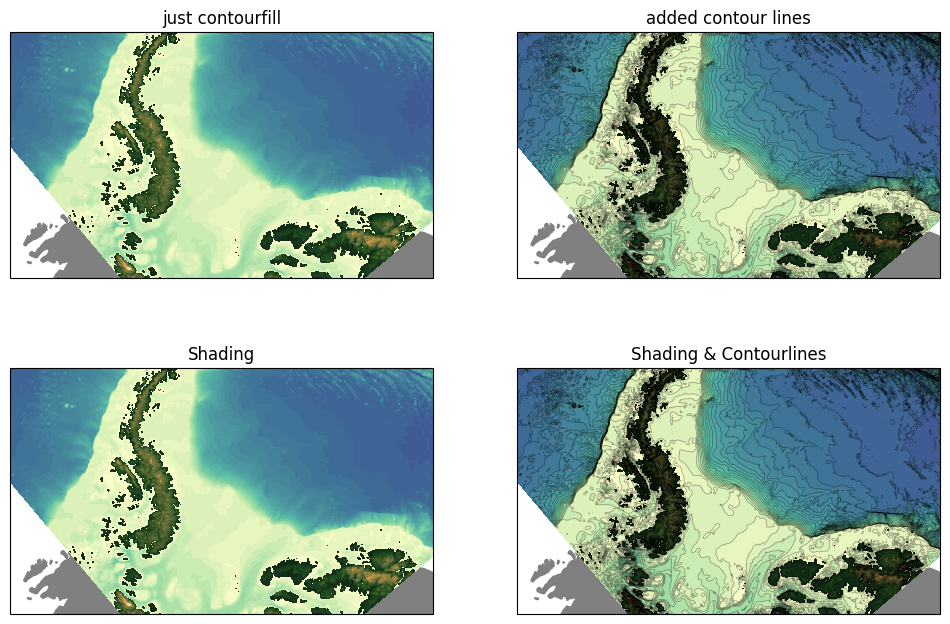

In [ ]:
# Define the projection for a high-resolution South Polar Stereographic map
high_res_proj = ccrs.SouthPolarStereo(central_longitude=-50)
#high_res_proj.threshold = 1e3

# Create a new figure and subplot with the specified projection
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': high_res_proj},
                        figsize=(12,8))

for ax in axs.flatten():
  # Add the land feature to the map with specified appearance
  ax.add_feature(cfeature.LAND, color="grey")
  ax.coastlines()

  # Define the limits for the x-axis and y-axis of the map
  xlim = [-80, -20] # longitude
  ylim = [-60, -80] # latitude

  # To make sure that all of the wanted map extent is visible in the figure,
  # (especially because the chosen map projections differs strongly
  # at the poles from the PlateCarree Projection)
  # this hack of adding a constant is needed and may need be adjusted,
  # dependent on your map extent and figure size
  ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]])
  divnorm = mcolors.TwoSlopeNorm(vcenter=0)
  image = ax.contourf(bat_lon, bat_lat, bat_z, 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)

axs[0,0].set_title("just contourfill")

axs[0,1].contour(bat_lon, bat_lat, bat_z, 60, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, transform=ccrs.PlateCarree())
axs[0,1].set_title("added contour lines")

hs = gvpy.maps.HillShade(bat_z, bat_lon, bat_lat)
axs[1,0].set_title("Shading")
axs[1,0].imshow(
    hs.smoothbumps,
    extent=hs.topo_extent,
    cmap=hs.kmap4,
    alpha=0.5,
    zorder=10,
    transform= ccrs.PlateCarree()
)

axs[1,1].set_title("Shading & Contourlines")
axs[1,1].imshow(
    hs.smoothbumps,
    extent=hs.topo_extent,
    cmap=hs.kmap4,
    alpha=0.5,
    zorder=10,
    transform= ccrs.PlateCarree()
)
axs[1,1].contour(bat_lon, bat_lat, bat_z, 60, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, transform=ccrs.PlateCarree())



## IBSCO Data set

In [ ]:
# tobeadded
url = "https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_RGB.tif"

# Satellite images

 <font color='red'> Only run the following cell if you are on Google Colab</font>

Uncomment the cell below if you are on Google Colab

In [ ]:
!pip install owslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 14.6 MB/s eta 0:00:00


In [ ]:
### This function is meant to replace an internal Python function ###

from owslib.wmts import TileMatrixSetLink, TileMatrixLimits
from owslib.wmts import _TILE_MATRIX_SET_TAG, _TILE_MATRIX_SET_LIMITS_TAG
from owslib.wmts import _TILE_MATRIX_LIMITS_TAG

def custom_from_elements(link_elements):
    links = []
    for link_element in link_elements:
        matrix_set_elements = link_element.findall(_TILE_MATRIX_SET_TAG)
        if len(matrix_set_elements) == 0:
            raise ValueError('Missing TileMatrixSet in %s' % link_element)
        elif len(matrix_set_elements) > 1:
            set_limits_elements = link_element.findall(
                _TILE_MATRIX_SET_LIMITS_TAG)
            if set_limits_elements:
                raise ValueError('Multiple instances of TileMatrixSet'
                                  ' plus TileMatrixSetLimits in %s' %
                                  link_element)
            for matrix_set_element in matrix_set_elements:
                uri = matrix_set_element.text.strip()
                links.append(TileMatrixSetLink(uri))
        else:
            uri = matrix_set_elements[0].text.strip()

            tilematrixlimits = {}
            path = '%s/%s' % (_TILE_MATRIX_SET_LIMITS_TAG,
                              _TILE_MATRIX_LIMITS_TAG)
            for limits_element in link_element.findall(path):
                tml = TileMatrixLimits(limits_element)
                if tml.tilematrix:
                    tilematrixlimits[tml.tilematrix] = tml

            links.append(TileMatrixSetLink(uri, tilematrixlimits))
    return links

TileMatrixSetLink.from_elements = custom_from_elements

<font color="blue">Remote Image</font>

Example 1:

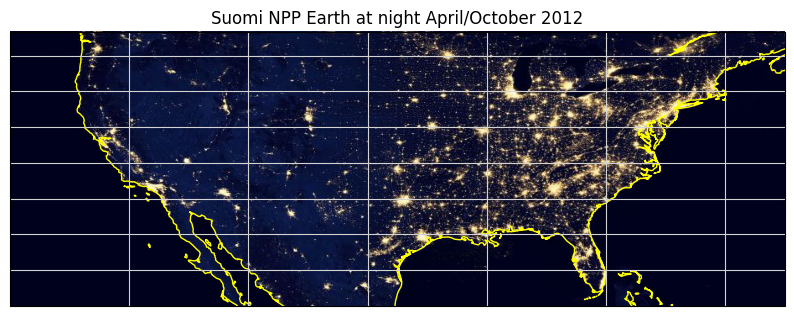

In [ ]:
# Define resource for the NASA night-time illumination data.

base_uri = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
layer_name = 'VIIRS_CityLights_2012'

#eng_boundingbox = [-6, 3, 48, 58]
usa_boundingbox = [-130, -65, 24, 47]

# Create a Cartopy crs for plain and rotated lat-lon projections.
plain_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 7))

# Plot WMTS data in a specific region, over a plain lat-lon map.
ax = fig.add_subplot(1, 1, 1, projection=plain_crs)
ax.set_extent(usa_boundingbox, crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='yellow')
ax.gridlines(color='lightgrey', linestyle='-')
# Add WMTS imaging.
ax.add_wmts(base_uri, layer_name=layer_name)

ax.set_title('Suomi NPP Earth at night April/October 2012')

plt.show()

Example 2:

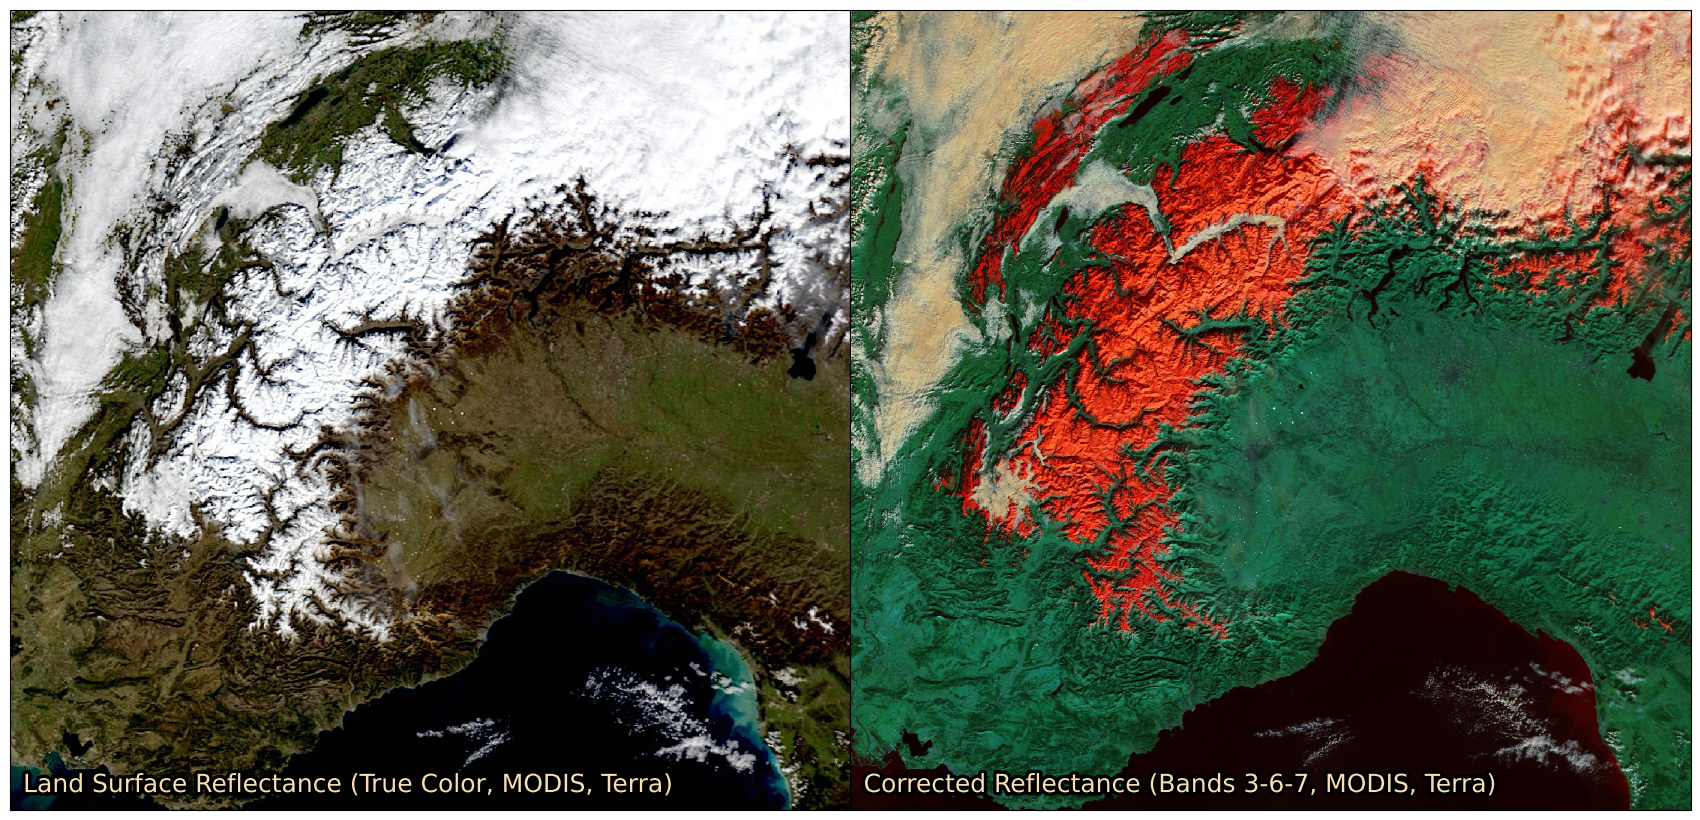

In [ ]:
import matplotlib.patheffects as PathEffects
from owslib.wmts import WebMapTileService

# URL of NASA GIBS
URL = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(URL)

# Layers for MODIS true color and snow RGB
layers = ['MODIS_Terra_SurfaceReflectance_Bands143',
          'MODIS_Terra_CorrectedReflectance_Bands367']

date_str = '2016-02-05'

# Plot setup
plot_CRS = ccrs.Mercator()
geodetic_CRS = ccrs.Geodetic()
x0, y0 = plot_CRS.transform_point(4.6, 43.1, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(11.0, 47.4, geodetic_CRS)
ysize = 8
xsize = 2 * ysize * (x1 - x0) / (y1 - y0)
fig = plt.figure(figsize=(xsize, ysize), dpi=100)

for layer, offset in zip(layers, [0, 0.5]):
    ax = fig.add_axes([offset, 0, 0.5, 1], projection=plot_CRS)
    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str})
    txt = ax.text(4.7, 43.2, wmts[layer].title, fontsize=18,
                  color='wheat', transform=geodetic_CRS)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5,
                                                 foreground='black')])
plt.show()


<font color="blue">Satellite Image</font>

In [ ]:
# Get the remote file
from urllib.request import urlopen
from PIL import Image
url = "https://lance-modis.eosdis.nasa.gov/imagery/gallery/2012270-0926/Miriam.A2012270.2050.2km.jpg"

img = Image.open(urlopen(url))

print("Type of object: ", type(img))
print("Image size:     ", img.size)

Type of object:  <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size:      (750, 975)


**Information on the file:** <a href="https://lance.modaps.eosdis.nasa.gov/imagery/gallery/2012270-0926/Miriam.A2012270.2050.txt">Tropical Storm Miriam (13E) off Mexico</a>

| Key  | Value |
| --- | --- |
| region | Pa |
| sat | Aqua |
| projection |Plate Carree |
| projection center lon |-113.5000 |
| projection center lat | +22.0000 |
| image center lon | -113.5 |
| image center lat | +22 |
| standard parallel | +20.0000 |
| UL lon |-120.6766 |
| UL lat |+30.7669 |
| UR lon | -106.3210 |
| UR lat | +30.7669 |
| LR lon | -106.3210 |
| LR lat | +13.2301 |
| LL lon | -120.6766 |
| LL lat | +13.2301 |
| UL easting (km) | -749.8750 |
| UL northing (km) | +3421.1250 |
| x scale factor | +0.9396926207859084 |
| ellipsoid | WGS84 |
| Contact | Jeff Schmaltz |
| L2 granules | A122702045 A122702050 |

Text(-117, 33, 'San Diego')

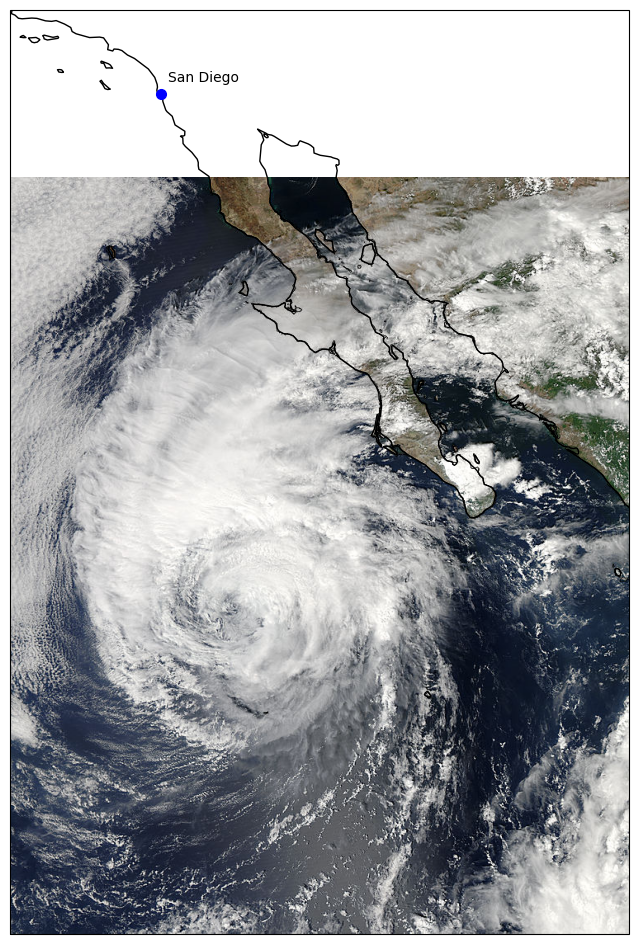

In [ ]:
fig = plt.figure(figsize=(8, 12))

img_extent = (-120.67660000000001, -106.32104523100001, \
              13.2301484511245, 30.766899999999502)

ax = plt.axes(projection=ccrs.PlateCarree())

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tif, the "origin" of
# the image is in the
# upper left corner
ax.imshow(img, origin='upper', extent=img_extent, \
          transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)

# mark a known place to help us geo-locate ourselves
ax.plot(-117.1625, 32.715, 'bo', markersize=7, transform=ccrs.Geodetic())
ax.text(-117, 33, 'San Diego', transform=ccrs.Geodetic())

# <font color="Green"> Cartopy and Shapefile Files</font>

## What is Shapefile?

The shapefile format:
* Is a digital vector storage format for storing geometric location and associated attribute information.
* Geographic features in a shapefile can be represented by points, lines, or polygons (areas).
* Is non-topological. It does not maintain spatial relationship information such as connectivity, adjacency, and area definition.
* Because the structure of points, lines, and polygons are different, each individual shapefile can only contain one vector type (all points, all lines or all polygons). You will not find a mixture of point, line and polygon objects in a single shapefile.
* Was introduced with ArcView GIS version 2 in the early 1990s.

#### Representation of the geographic features of a shapefile

![features](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/points-lines-polygons-vector-data-types.png)
Image Source: Colin Williams (NEON)


## Content of Shapefile Files

Every shapefile data set includes at least three files:

* **.shp**: The main file that contains the primary geographic reference data and records of various shape types included, such as points, polygons, or multipatches.
* **.dbf**: The dBase file that stores attributes for each shape. It alows quicker access to the spatial features of the data.
* **.shx**: Organize the records of a shapefile for reference.

These files need to have the same name and to be stored in the same directory (folder).

Sometimes, a shapefile will have other associated files including:

* **.prj**: Contains information on projection format including the coordinate system and projection information. It is a plain text file describing the projection using well-known text (WKT) format.
* **.sbn** and **.sbx**: the files that are a spatial index of the features.
* **.shp.xml**: the file that is the geospatial metadata in XML format, (e.g. ISO 19115 or XML format).

#### Spatial Data Attributes

- Each object in a shapefile has one or more attributes associated with it.
- Shapefile attributes are similar to fields or columns in a spreadsheet.
- Each row in the spreadsheet has a set of columns associated with it that describe the row element.
- Attribute data are stored in the **.dbf** file.

![attributes](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-attribute-tables.png)
Image Source: National Ecological Observatory Network (NEON)

<font color="green"> EXAMPLE: Color all the "counties" in Belgium</font>

In [ ]:
# Obtain the remote shapefile files
import urllib.request

url = 'https://raw.githubusercontent.com/astg606/py_materials/master/visualization/borders/'

file_list = ["BEL_adm3.csv", "BEL_adm3.dbf", "BEL_adm3.prj", "BEL_adm3.shp", "BEL_adm3.shx"]

for file in file_list:
    urllib.request.urlretrieve(url+file, file)

NameError: ignored

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


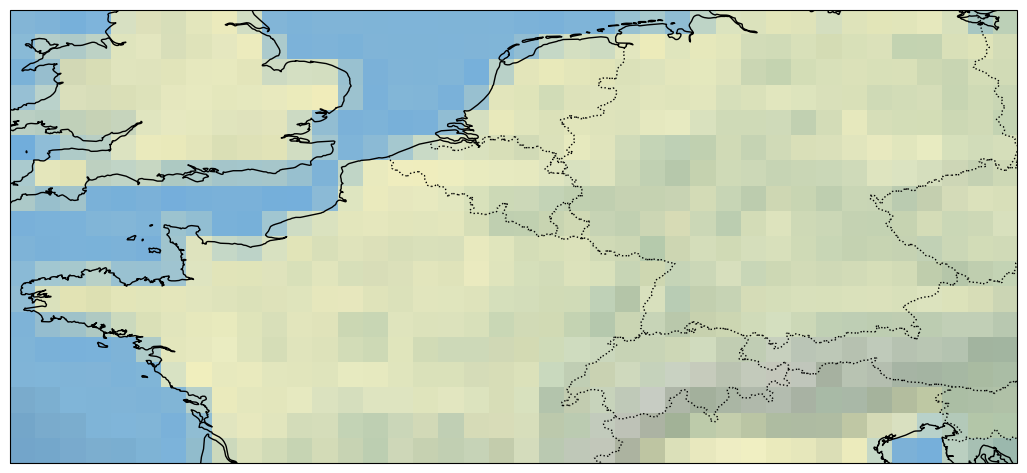

In [ ]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(13, 11),
                       subplot_kw=subplot_kw)

# Create a map of Europe
#---------------------------
lower_lon = -5.0
upper_lon = 15.
lower_lat = 45.
upper_lat = 54.

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

# Put a background image on for nice sea rendering.
ax.stock_img()

ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# Get the shapes  (from the shp file) and
#         records (from the dbf files)
# ---------------------------------------
reader = shapereader.Reader('BEL_adm3')

# The read shapefile method allows you to call the shapefile's shapes and info.
# Both are lists, the first containing a list of tuples (coordinates),
# and the second containig a dictionary with associated metadata

# Plots the shapes as Polygons with a random facecolor
for country in reader.geometries():
    ax.add_geometries([country], ccrs.PlateCarree(), \
                      facecolor=cm.jet(np.random.rand()), \
                      edgecolor='black')

plt.show()

## Use Shapefiles to show Scales

In [ ]:
# to be added

#Cartopy and the Natural Earth Dataset

* Cartopy provides an interface for access to frequently used data such as the <a href="https://www.ngdc.noaa.gov/mgg/shorelines/gshhs.html">GSHHS</a> dataset and from the <a href="http://www.naturalearthdata.com">NaturalEarthData</a> website.
* These interfaces allow the user to define the data programmatically, and if the data does not exist on disk, it will be retrieved from the appropriate source (normally by downloading the data from the internet).

**You can use the Natural Earth Data database to have higher-resolution features:**

In [ ]:
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
#ax.add_feature(cartopy.feature.RIVERS, edgecolor='b')
ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax.gridlines()

In [ ]:
fig = plt.figure(figsize=(12, 5))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([80, 170, -45, 30], crs=ccrs.PlateCarree())

# Put a background image on for nice sea rendering.
ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

plt.show()

**To acquire the countries dataset from Natural Earth, we may use:**

In [ ]:
import cartopy.io.shapereader as shapereader

shpfilename = shapereader.natural_earth(resolution='110m', \
                                      category='cultural', \
                                      name='admin_0_countries')

The function `Reader` provides an interface for accessing the contents of a shapefile. It returns an instance that has two primary methods:

* **geometries()**: Returns an iterator of shapely geometries from the shapefile.
* **records()**: Returns an iterator of Record (entry of the file that combines attributes with their associated geometry) instances.

In [ ]:
reader = shapereader.Reader(shpfilename)
countries = reader.records()
country = next(countries)

In [ ]:
print(type(country.attributes))

In [ ]:
for key in country.attributes:
    print("{:} --> {:>}".format(key, country.attributes[key]))

<font color="blue"> EXAMPLE: Map the Globe and Color the United States</font>

In [ ]:
# Select the map projection
#----------------------
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN)

# Select the area of interest
#-----------------------
ax.set_extent([-130, -65, 24, 47])

for country in countries:
    if country.attributes['ADM0_A3'] == 'USA':
        ax.add_geometries(country.geometry, \
                          ccrs.PlateCarree(), \
                          facecolor=(0, 0, 1),
                          label=country.attributes['ADM0_A3'])
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0, 1, 0), \
                          label=country.attributes['ADM0_A3'])

plt.show()

**Exercise:**
Draw the USA map and randomly color each state.

You may want to use:

```python
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shapereader.natural_earth(resolution='110m',
                                       category='cultural',
                                       name=shapename)

reader = shapereader.Reader(states_shp)
```

<font color="blue"> EXAMPLE: Select the country Cameroon and color each of its administrative region with a different color </font>

In [ ]:
from matplotlib.colors import cnames
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Read the Natural Earth shapefile dataset
#----------------------------------
kw = dict(resolution='10m', category='cultural', \
          name='admin_1_states_provinces')
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

# Select the map projection
#----------------------
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(7, 11), subplot_kw=subplot_kw)

# Select the area that includes Cameroon
#----------------------------------
ax.set_extent([7.85, 17.05, 1.475, 13.50])
#ax.set_extent([7.5, 17.5, 1.25, 15])

#ax.background_patch.set_visible(False)
#ax.outline_patch.set_visible(False)

# Get from Matplotlib a list of colors
#------------------------------
colors = list(cnames.keys())
len_colors = len(colors)

k = 0
for record, state in zip(shp.records(), shp.geometries()):
    if record.attributes['admin'] == 'Cameroon':
        if k+1 == len_colors:
            k = 0
        else:
            k += 1
        facecolor = colors[k]
        ax.add_geometries([state], ccrs.PlateCarree(), \
                      facecolor=facecolor, edgecolor='black')
    else:
        facecolor = 'LightGray'
#    ax.add_geometries([state], ccrs.PlateCarree(), \
#                      facecolor=facecolor, edgecolor='black')

plt.show()

# Cartopy vs Basemap

**Basemap is a predecessor of Cartopy and is deprecated, but you may still be  stumbling onto some old scripts using it.**

## Example: Converting a Basemap Script into a Cartopy Script

The main differences between Cartopy and Basemap are:

1) The way they create plotting axes

     - Basemap: create the Basemap instance.
     - Cartopy: create the plotting axis by passing the projection to the axes constructor.

2) The way they set the plot extent

     - Basemap: pass the x,y corners of the plot either as lon,lat values for the upper right and lower left corners, or as a width and height in x,y units.
     - Cartopy: pass the x,y corners using for instance the set_extent method.

**Basemap**
```python
fig = plt.figure(num=None, figsize=(8,5), facecolor='w')
text1=''
fig.text(0.45, 0.93, text1,color='b')

cxcoord4  = [0.91, 0.2, 0.015, 0.6]

m = Basemap(projection='cyl',\
    llcrnrlon=lon_1,llcrnrlat=lat_01,urcrnrlon=lon_2,urcrnrlat=lat_02,\
    lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,lat_2=truelat2,suppress_ticks=False)

x, y = m(-98.3125, 48.8125)
plt.plot(x, y, 'ok', markersize=5)
x, y = m(-72.31250, 41.9375)
plt.plot(x, y, 'ok', markersize=5)

m.drawcoastlines(color='grey')
m.drawcountries(color='grey')
m.drawstates(color='grey')

clev=np.arange(Tmin,Tmax+1,1)
jet = plt.get_cmap('jet')
cs = plt.contourf(lon0,lat0,var1,clev,cmap=jet,extend='neither')
plt.title('')
cx  = fig.add_axes(cxcoord4)
cbar=plt.colorbar(cs,cax=cx,orientation='vertical',
                  ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
```

**Cartopy**
```python
def get_indices(my_array, my_list):
    list_indices = []
    for item in  my_list:
        list_indices.append((np.abs(my_array - item)).argmin())
    return list_indices

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastline, borders and states
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='grey')
ax.add_feature(cartopy.feature.BORDERS,   edgecolor='grey')
ax.add_feature(cartopy.feature.STATES,    edgecolor='grey')

# Plot specific points
#---------------------
i = get_indices(lon0[0,:], [-98.3125, -72.31250])
j = get_indices(lat0[:,0], [48.8125, 41.9375])
plt.plot(lon0[0,i],lat0[j,0], 'ok', markersize=5)

# Contour plot and Colorbar
#-------------------------
clev=np.arange(Tmin,Tmax+1,1)
jet = plt.get_cmap('jet')
cs = ax.contourf(lon0,lat0,var1,clev,cmap=jet,extend='neither', transform=ccrs.PlateCarree())
plt.title('')
cx  = fig.add_axes(cxcoord4)
cbar=plt.colorbar(cs,cax=cx,orientation='vertical',
                  ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# set the extent of the plot
#---------------------------
ax.set_extent([lon_1, lon_2, lat_01, lat_02], crs=ccrs.PlateCarree())

```